# Idiosyncratic Market Value Factor: 
# Explaining market value by machine learning methods

## Idea
At a given specific time point, market value explanition models think market values of listed firms can be explained by theirs financial informations and market factors.  
Under such assumptions, these models will induce an intrinsic market value of a listed firms at a specific time, however, there's always a residue term, which is also the difference between intrinsic value and current market value.  
We name this residue term as Idiosyncratic Market Value Factor, larger this factor is, indicating more upper bias is between current firm value and intrinsic value, by the idea of mean-reverting, it is more likely for the stock price to drop.  
In other words, this is a way of relative valuation and a smaller IMVF indicates a better performance of the stock. 

## Variables explanation
* $ m_{it} $ is the log-market value of stock $i$ at time $t$  
* $ IND_{it} $ is the dummy variables of different industries  
* $ b_{it} $ is the log-net asset of stock $i$ at time $t$, except firms whose net asset is negtive    
* $ Ln(NI)^+_{it}$ and $ Ln(NI)^-_{it}$ are net income of stock $i$ at time $t$ according to whether their sign  
* $ LEV_{it} $ is firm's financial leverage  
* $ g_{it} $ is the revenue growth rate (YoY quarterly)   
* $ RD_{it} $ is the log-R&D expense, None is replaced by 0  

# First sight: Linear Regression

Consider following model:  
$$ m_{it} = a_{0t}IND_{it}+a_{1t}b_{it}+a_{2t}Ln(NI)^+a_{3t}I_{<0}Ln(NI)^-_{it}+a_{4t}LEV_{it}+a_{5t}g_{it}+a_{6t}RD_{it}+\epsilon_{it} $$

## Machine Learning method: Random Forest
Consider Random Forest model:  
$$ m_{it} = RF(IND_{it},b_{it},Ln(NI)^,Ln(NI)^-_{it},LEV_{it},g_{it},RD_{it})+\epsilon_{it} $$

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [21]:
from quarter2month import quarter2month
from Winsorize_Fillna_Neutralize import Winsorize_Fillna_Neutralize
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor

## In this part, we will construct the idiosyncratic market value

### Load the raw data

In [9]:
# Input raw data
comp_frm=pd.read_csv('./data/industrycomp.csv')
netasset_raw=pd.read_excel('./data/netasset.xlsx')
netprofit_raw=pd.read_excel('./data/netprofit_q.xlsx')
lev_raw=pd.read_excel('./data/debt2asset.xlsx')
yoysales_raw=pd.read_excel('./data/yoysales.xlsx')
rd_raw=pd.read_excel('./data/rd.xlsx')
value_frm=pd.read_csv('./data/value.csv')
retf1_frm=pd.read_csv('./data/retf1.csv')
limit_status_frm=pd.read_csv('./data/limit_status_st.csv',encoding='gb18030')
tdate=list(value_frm['date'].drop_duplicates())

### Transform the seasonal data to monthly data

In [10]:
netasset_frm=quarter2month(tdate,netasset_raw,'netasset')
netprofit_frm=quarter2month(tdate,netprofit_raw,'netprofit')
lev_frm=quarter2month(tdate,lev_raw,'lev')
yoysales_frm=quarter2month(tdate,yoysales_raw,'yoysales')
rd_frm=quarter2month(tdate,rd_raw,'rd')

### Merge data

In [11]:
data=pd.merge(value_frm,netasset_frm,how='inner',on=['date','code'])
data=pd.merge(data,netprofit_frm,how='inner',on=['date','code'])
data=pd.merge(data,lev_frm,how='inner',on=['date','code'])
data=pd.merge(data,yoysales_frm,how='inner',on=['date','code'])
data=pd.merge(data,rd_frm,how='inner',on=['date','code'])
data=pd.merge(data,comp_frm,how='inner',on=['code'])
data=pd.merge(data,retf1_frm,how='inner',on=['date','code'])
data=pd.merge(data,limit_status_frm,how='inner',on=['date','code'])
data=data[['date','code','totalmv','netasset','netprofit','lev','yoysales','rd','industry','retf1','limit','status']]

In [17]:
data.head()

,date,code,totalmv,netasset,netprofit,lev,yoysales,rd,industry,retf1,limit,status,logmv,lognetasset,netprofit_abs,lognetprofit,ni_negative
121,20070131,000002.SZ,6.690315e+06,9.948030e+09,1.456485e+09,72.1260,50.5017,0.0,CI005023.WI,-0.037233,0.0,交易,15.716172,23.020640,1.456485e+09,21.099292,0.0
450,20070131,000006.SZ,3.025348e+05,1.236908e+09,1.772558e+08,55.7914,-20.4864,0.0,CI005023.WI,0.081375,0.0,交易,12.619952,20.935881,1.772558e+08,18.993104,0.0
573,20070131,000007.SZ,5.382492e+04,6.396426e+07,-2.582537e+07,88.7987,78.1794,0.0,CI005023.WI,0.294960,0.0,交易,10.893492,17.973835,2.582537e+07,17.066868,1.0
621,20070131,000008.SZ,4.124580e+04,7.230798e+07,-6.278618e+05,7.1045,-74.1205,0.0,CI005010.WI,0.143159,0.0,交易,10.627304,18.096445,6.278618e+05,13.350075,1.0
1036,20070131,000012.SZ,1.298777e+06,2.559077e+09,3.173672e+08,55.4746,28.0972,0.0,CI005008.WI,0.133759,0.0,交易,14.076934,21.662912,3.173672e+08,19.575570,0.0


### Construct responding variable

In [18]:
data=data.loc[np.where((~np.isnan(data['totalmv'])) & (~np.isnan(data['netasset'])) & (data['netasset']>0) & (~np.isnan(data['netprofit'])) & (~np.isnan(data['lev'])) & (~np.isnan(data['yoysales'])) & (~np.isnan(data['retf1'])) & (data['limit']==0) & (data['status']=='交易'))[0]]
data=data.reset_index(drop=True)
data['rd']=data['rd'].fillna(0)
data.loc[np.where(data['rd']>0)[0],'rd']=1
data['logmv']=np.log(data['totalmv'])
data['lognetasset']=np.log(data['netasset'])
data['netprofit_abs']=np.abs(data['netprofit'])
data['lognetprofit']=np.log(data['netprofit_abs'])
data.loc[np.where(data['netprofit']<0)[0],'ni_negative']=1
data['ni_negative']=data['ni_negative'].fillna(0)
data=data.sort_values(by=['date','code'],axis=0,ascending=True)
datadate=list(data['date'].drop_duplicates())

In [14]:
data.head()

,date,code,totalmv,netasset,netprofit,lev,yoysales,rd,industry,retf1,limit,status,logmv,lognetasset,netprofit_abs,lognetprofit,ni_negative
121,20070131,000002.SZ,6.690315e+06,9.948030e+09,1.456485e+09,72.1260,50.5017,0.0,CI005023.WI,-0.037233,0.0,交易,15.716172,23.020640,1.456485e+09,21.099292,0.0
450,20070131,000006.SZ,3.025348e+05,1.236908e+09,1.772558e+08,55.7914,-20.4864,0.0,CI005023.WI,0.081375,0.0,交易,12.619952,20.935881,1.772558e+08,18.993104,0.0
573,20070131,000007.SZ,5.382492e+04,6.396426e+07,-2.582537e+07,88.7987,78.1794,0.0,CI005023.WI,0.294960,0.0,交易,10.893492,17.973835,2.582537e+07,17.066868,1.0
621,20070131,000008.SZ,4.124580e+04,7.230798e+07,-6.278618e+05,7.1045,-74.1205,0.0,CI005010.WI,0.143159,0.0,交易,10.627304,18.096445,6.278618e+05,13.350075,1.0
1036,20070131,000012.SZ,1.298777e+06,2.559077e+09,3.173672e+08,55.4746,28.0972,0.0,CI005008.WI,0.133759,0.0,交易,14.076934,21.662912,3.173672e+08,19.575570,0.0


### Construct linear_IMV and randomforest_IMV

In [25]:
linear_params = []
rf_importance = []
r_squared = []
R_square_rf=[]
for i in range(len(datadate)):#
    print('Calculating Idiosyncratic Market Value in Period: '+str(datadate[i]))
    data_sel=data[data.date==datadate[i]]
    industrydummies=pd.get_dummies(data_sel['industry'])
    x_mat=pd.concat([industrydummies,data_sel['lognetasset'],data_sel['lognetprofit'],
                     data_sel['ni_negative']*data_sel['lognetprofit'],data_sel['lev'],data_sel['yoysales'],data_sel['rd']],axis=1)
    x=sm.add_constant(x_mat)
    y=np.array(data_sel['logmv'])
    model = sm.OLS(y,x)
    results = model.fit()
    data_sel['linear_spemv']=results.resid
    linear_params.append(pd.DataFrame(results.params,columns=[datadate[i]]))
    r_squared.append(results.rsquared)
    rf=RandomForestRegressor(n_estimators=500)
    rf.fit(x_mat,y)
    data_sel['rf_spemv']=y-rf.predict(x_mat)
    TSS=np.dot(y-np.mean(y),y-np.mean(y))
    ESS=np.dot(rf.predict(x_mat)-np.mean(y),rf.predict(x_mat)-np.mean(y))
    R_square_rf.append(ESS/TSS)
    rf_importance.append(pd.DataFrame(rf.feature_importances_,index=x_mat.columns,columns=[datadate[i]]))
    if i==0:
        data_new=data_sel
    else:
        data_new=pd.concat([data_new,data_sel],axis=0)

Calculating Idiosyncratic Market Value in Period: 20070131
Calculating Idiosyncratic Market Value in Period: 20070228
Calculating Idiosyncratic Market Value in Period: 20070330
Calculating Idiosyncratic Market Value in Period: 20070430
Calculating Idiosyncratic Market Value in Period: 20070531
Calculating Idiosyncratic Market Value in Period: 20070629
Calculating Idiosyncratic Market Value in Period: 20070731
Calculating Idiosyncratic Market Value in Period: 20070831
Calculating Idiosyncratic Market Value in Period: 20070928
Calculating Idiosyncratic Market Value in Period: 20071031
Calculating Idiosyncratic Market Value in Period: 20071130
Calculating Idiosyncratic Market Value in Period: 20071228
Calculating Idiosyncratic Market Value in Period: 20080131
Calculating Idiosyncratic Market Value in Period: 20080229
Calculating Idiosyncratic Market Value in Period: 20080331
Calculating Idiosyncratic Market Value in Period: 20080430
Calculating Idiosyncratic Market Value in Period: 200805

### The average of r_square in Linear model and RandomForest model

In [26]:
np.mean(r_squared)

0.7948704345688904

In [27]:
np.mean(R_square_rf)

0.8969009269123783

### Analyze the linear params significance and feature importance

In [28]:
lr_params = pd.concat(linear_params,axis=1).T
lr_params.index = pd.to_datetime([str(dt) for dt in lr_params.index])
rf_im=pd.concat(rf_importance,axis=1).T
rf_im.index = pd.to_datetime([str(dt) for dt in rf_im.index])

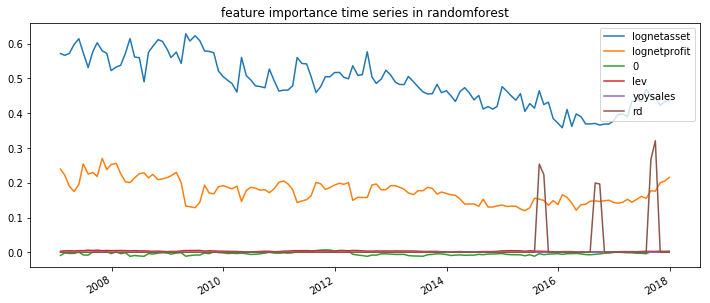

In [29]:
lr_params.iloc[:,-6:].plot(figsize=(12,5),title='feature importance time series in randomforest')

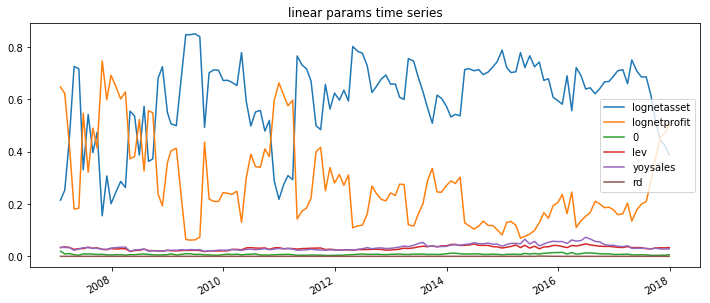

In [30]:
rf_im.iloc[:,-6:].plot(figsize=(12,5),title='linear params time series')

In [31]:
# calculate t-statistics
def t(s):
    dev = np.sqrt(np.power(s-s.mean(),2).sum()/(len(s)-1))
    return s.mean()/dev

### Linear model parameter significance and mean

In [32]:
lr_t = lr_params.iloc[:,-6:].agg([t,np.mean]).T

In [33]:
lr_t

,t,mean
lognetasset,7.063372,0.488900
lognetprofit,5.293597,0.175467
0,-0.898149,-0.003875
lev,2.334264,0.003085
yoysales,0.418659,0.000022
rd,0.213878,0.011065


### Random forest feature importance

In [34]:
rf_t = rf_im.iloc[:,-6:].apply(np.mean).T

In [35]:
pd.DataFrame(rf_t,columns=['feature_importance'])

,feature_importance
lognetasset,0.599446
lognetprofit,0.277495
0,0.007619
lev,0.031348
yoysales,0.034898
rd,0.000019


### Winsorize and Neutralize

In [36]:
# Factor processing
data_new=Winsorize_Fillna_Neutralize(data_new,'linear_spemv')
data_new=Winsorize_Fillna_Neutralize(data_new,'rf_spemv')
# data_new.to_csv('data2.csv',index=False)

In [37]:
data=pd.read_csv('./data/data3.csv',encoding='gb18030')
data.date = pd.to_datetime([str(dt) for dt in data.date])

In [38]:
data.head(3)

,date,code,totalmv,netasset,netprofit,lev,yoysales,rd,industry,retf1,limit,status,logmv,lognetasset,netprofit_abs,lognetprofit,ni_negative,linear_spemv,rf_spemv
0,2007-01-31,000002.SZ,6.690315e+06,9.948030e+09,1.456485e+09,72.1260,50.5017,0,CI005023.WI,-0.037233,0,交易,15.716172,23.020640,1.456485e+09,21.099292,0,0.039493,-1.000270
1,2007-01-31,000006.SZ,3.025348e+05,1.236908e+09,1.772558e+08,55.7914,-20.4864,0,CI005023.WI,0.081375,0,交易,12.619952,20.935881,1.772558e+08,18.993104,0,-1.233260,-0.932409
2,2007-01-31,000007.SZ,5.382492e+04,6.396426e+07,-2.582537e+07,88.7987,78.1794,0,CI005023.WI,0.294960,0,交易,10.893492,17.973835,2.582537e+07,17.066868,1,0.958505,-0.025166


## In second part, we will test the factors by IC and group backtest method

### Define IC method

In [39]:
def ic_timeseries(data,factor_name):
    
    assert('date' in data.columns)
    assert(factor_name in data.columns)
    
    dtList = list(data.date.drop_duplicates())
    rank_ic = []
    for dt in dtList:
        data1 = data[data.date == dt]
        rank_ic.append(data1[[factor_name,'retf1']].corr(method='spearman').values[0][1])

    return pd.DataFrame(rank_ic,index=dtList,columns=['ic']) 

In [40]:
def show_ic_analysis(data,factor_name):

    ic_ts = ic_timeseries(data,factor_name)
    
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)

    title1 = '%s IC time series' % factor_name
    ic_ts.plot(title=title1, ax=ax1)

    title2 = '%s IC histogram' % factor_name
    ic_ts.plot.hist(stacked=True, bins=20, title=title2, ax=ax2)

    title3 = '%s IC Box-plot' % factor_name
    ic_ts.plot.box(sym='r+', title=title3, ax=ax3)

    plt.tight_layout()
    plt.show()
    return 

### Define group backtest method

In [41]:
def group_backtest(data,factor_name,groups):
    
    assert('date' in data.columns)
    assert(factor_name in data.columns)
    
    gp_rets = {}
    benchmark_rets = {}
    
    dtList = list(data.date.drop_duplicates())
    for dt in dtList:
        df = data[data.date == dt]
        df['group'] = pd.qcut(df[factor_name], groups, labels=['Top%d' % i for i in range(1, groups + 1)])
        gp_rets[dt] = df.groupby(['group']).retf1.mean()
        benchmark_rets[dt] = df['retf1'].mean()
        
    rets_df = pd.DataFrame(gp_rets).T
    rets_df.columns = rets_df.columns.categories  #transform the CategoricalIndex to Index so that merge benchmark
    rets_df = pd.concat([rets_df,pd.DataFrame(benchmark_rets,index=['benchmark']).T],axis=1)
    rets_df['Top1/Top%d' % groups] =  rets_df.Top1 - rets_df['Top%d' % groups]
    rets_df['Top%d/benchmark' % groups] = rets_df['Top%d' % groups] - rets_df.benchmark
    rets_df['Top1/benchmark'] = rets_df['Top1'] - rets_df.benchmark
    rets_df = (rets_df+1).cumprod() 
    
    return rets_df

In [42]:
def show_group_analysis(data,factor_name,groups):
    
    col = ['Top%d' % i for i in range(1,groups+1)]
    col.extend(['benchmark'])
    pnls = group_backtest(data,factor_name,groups)
    pnls2 = pnls.loc[:, col]

    fig = plt.figure(figsize=(12, 15))
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)

    pnls2.plot(title='%s net value of different groups' % factor_name, ax=ax1)
    pnls2.iloc[:,:-1].div(pnls.benchmark,axis=0).plot(title='%s net value to benchmark' % factor_name, ax=ax2)
    pnls.loc[:,['Top1/Top%d' % groups]].plot(ax=ax3,title='%s Top1 Vs Top%d net value ratio' % (factor_name, groups))
    plt.tight_layout()
    plt.show()
    
    return

### Calculate performance statistics

In [43]:
# Calculating Sharpe_ratio (according to excess return and pl is net value)
def sharp_ratio(pl):
    '''
    pl: net value curve series, pandas.series
    '''
    net_rets = pl.pct_change()
    dev = np.std(net_rets, ddof=1)
    mean = np.mean(net_rets, axis=0)
    ir = mean * np.sqrt(242/12) / dev
    return ir


# Annualized volatility pl is net value
def annual_volatility(pl):
    '''
     pl: net value curve series, pandas.series
    '''
    net_rets = pl.pct_change()
    return np.std(net_rets, ddof=1) * np.sqrt(242/12)


# Annualized rate of return
def annual_ret(pl):
    '''
    pl: net value curve series, pandas.series，pl.index need to be pandas.DatetimeIndex
    '''
    # calculate the number of years between two dates
    diff = pl.index[-1] - pl.index[0]
    diff_in_years = (diff.days + diff.seconds / 86400) / 365.2425
    # calculate compound annual growth rate
    B = pl[-1]
    A = pl[0]
    return np.power(B / A, 1 / diff_in_years) - 1


# Annualized return rate drawdown ratio, pl is net value
def calmar_ratio(pl):
    '''
    pl: net value curve series, pandas.series，pl.index 需为pandas.DatetimeIndex格式
    '''
    return annual_ret(pl) / np.max(1 - pl / pl.expanding().max())


# Maximum drawdown, pl is net value
def max_drawdown(pl):
    '''
    pl: net value curve series, pandas.series，pl.index 需为pandas.DatetimeIndex格式
    '''
    return np.max(1 - pl / pl.expanding().max())


# Backtest
def backtest_stats(pl, by_year=True):
    '''
    pl: net value curve series, pandas.series
    by_year:  True or False
    '''
    # Transform pl.index into pandas.DatetimeIndex
    pl.index = pd.DatetimeIndex(pl.index)
    if by_year:
        return pl.groupby(pl.index.year).agg([annual_ret, annual_volatility, max_drawdown, sharp_ratio, calmar_ratio])
    else:
        return pl.agg([annual_ret, annual_volatility, max_drawdown, sharp_ratio, calmar_ratio])

### Result

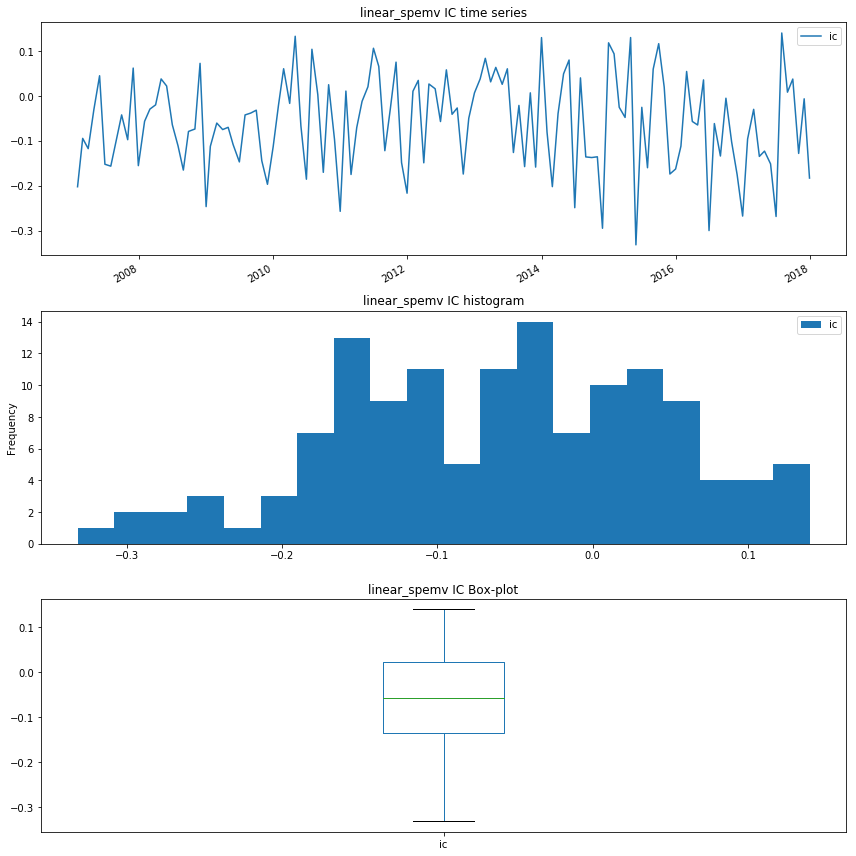

In [44]:
show_ic_analysis(data,'linear_spemv')

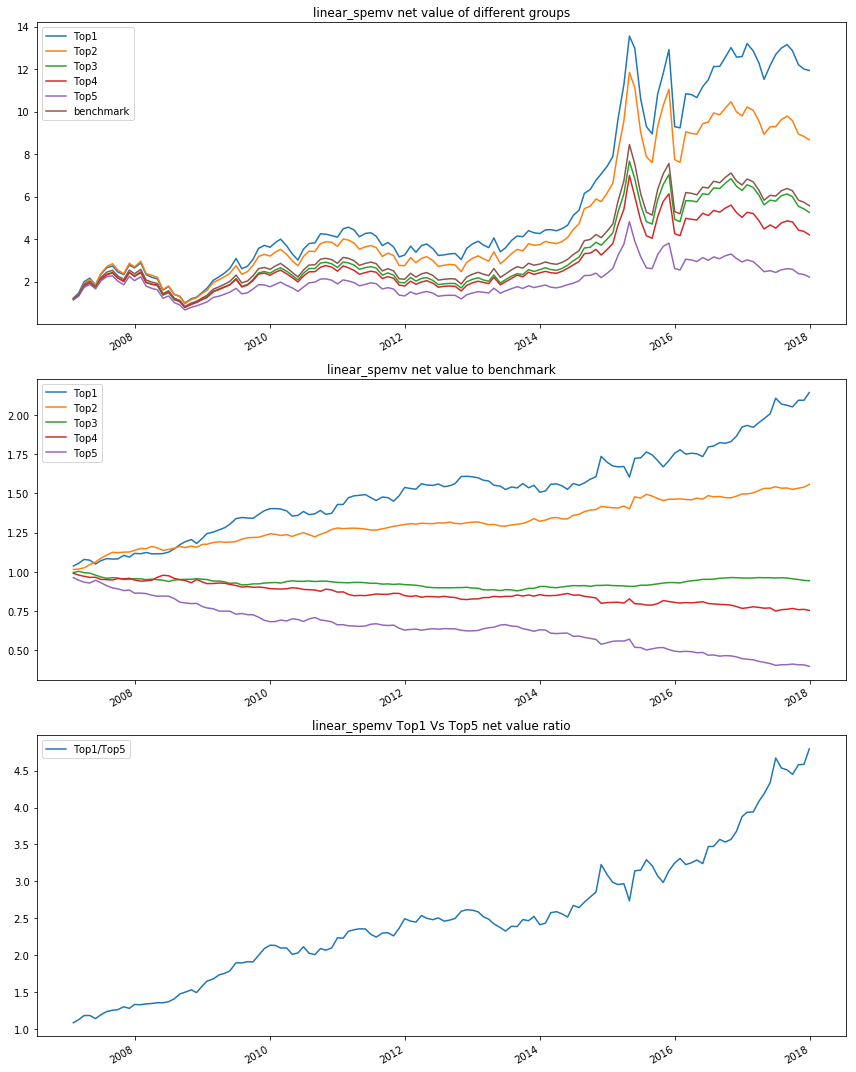

In [45]:
show_group_analysis(data,'linear_spemv',5)

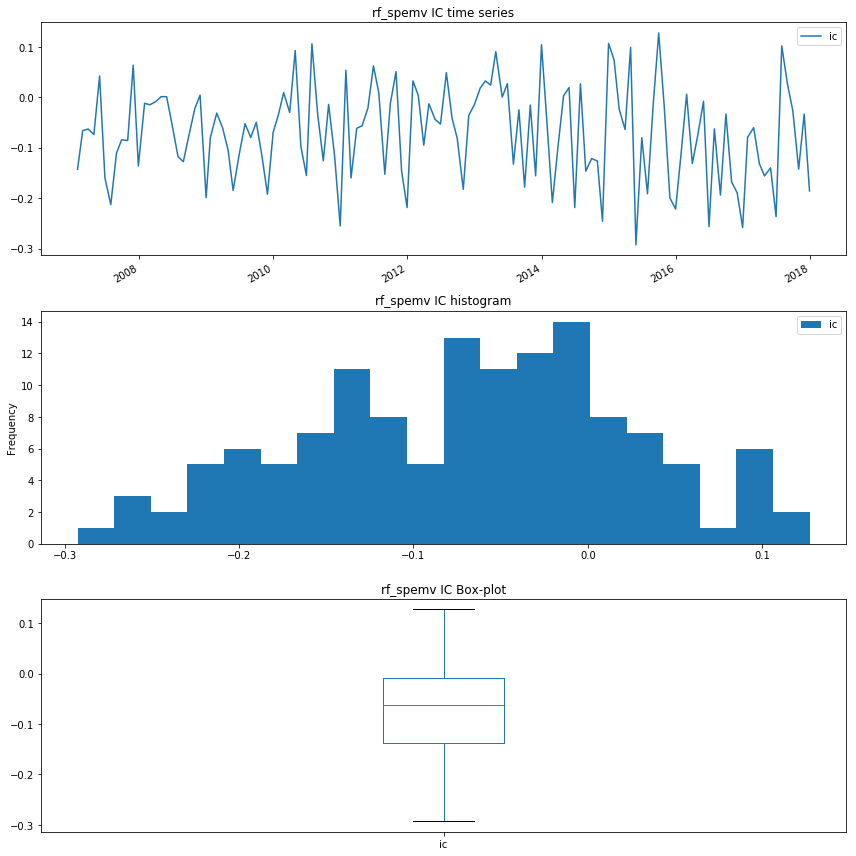

In [46]:
show_ic_analysis(data,'rf_spemv')

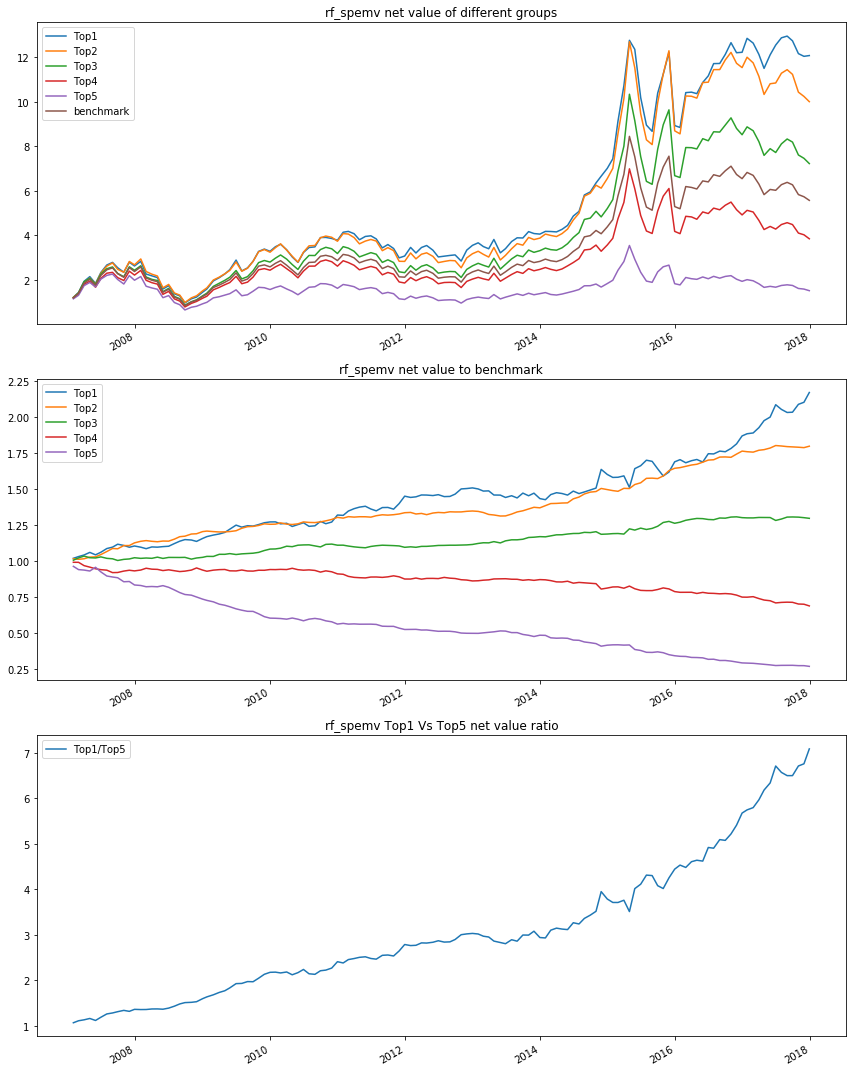

In [47]:
show_group_analysis(data,'rf_spemv',5)

In [48]:
lr_df = group_backtest(data,'linear_spemv',5)

In [49]:
backtest_stats(lr_df, by_year=False).T

,annual_ret,annual_volatility,max_drawdown,sharp_ratio,calmar_ratio
Top1,0.231686,0.479012,0.655236,0.973943,0.353592
Top2,0.198539,0.488297,0.675594,0.870741,0.293873
Top3,0.146720,0.485989,0.678418,0.718859,0.216268
Top4,0.124029,0.492906,0.677506,0.646768,0.183067
Top5,0.062762,0.497189,0.706185,0.456107,0.088874
benchmark,0.152446,0.485467,0.677218,0.736089,0.225106
Top1/Top5,0.145499,0.146026,0.152071,1.641887,0.956780
Top5/benchmark,-0.076397,0.069924,0.579828,-1.867399,-0.131758
Top1/benchmark,0.064900,0.081907,0.088960,1.333013,0.729542


In [52]:
backtest_stats(lr_df, by_year=True).T

2007      2008        2009      2010  \
Top1           annual_ret         1.332435 -0.503397    1.264256  0.070991   
               annual_volatility  0.737476  0.757735    0.473919  0.383673   
               max_drawdown       0.149554  0.655236    0.155906  0.246424   
               sharp_ratio        2.284037 -1.151465    3.277757  0.472127   
               calmar_ratio       8.909412 -0.768268    8.109089  0.288085   
Top2           annual_ret         1.434716 -0.536484    1.111821  0.086152   
               annual_volatility  0.713884  0.769308    0.450931  0.363953   
               max_drawdown       0.166662  0.675594    0.149610  0.219171   
               sharp_ratio        2.447372 -1.259556    3.139757  0.545139   
               calmar_ratio       8.608530 -0.794093    7.431465  0.393081   
Top3           annual_ret         1.055041 -0.548789    0.945506  0.049860   
               annual_volatility  0.696195  0.743074    0.460707  0.359655   
               max_drawdown       0.177445  0.678418    0.171350  0.214339   
               sharp_ratio        2.067307 -1.385711    2.762357  0.388243   
               calmar_ratio       5.945750 -0.808924    5.517986  0.232621   
Top4           annual_ret         1.046331 -0.550911    0.917683  0.022364   
               annual_volatility  0.683508  0.737293    0.466857  0.353121   
               max_drawdown       0.161043  0.675650    0.169511  0.219566   
               sharp_ratio        2.082160 -1.408450    2.674277  0.263841   
               calmar_ratio       6.497226 -0.815380    5.413705  0.101853   
Top5           annual_ret         0.907217 -0.596462    0.749327  0.014263   
               annual_volatility  0.681877  0.738104    0.439502  0.364472   
               max_drawdown       0.183274  0.700316    0.154830  0.220068   
               sharp_ratio        1.904734 -1.634351    2.435825  0.229154   
               calmar_ratio       4.950047 -0.851704    4.839687  0.064813   
benchmark      annual_ret         1.148430 -0.547818    0.991360  0.049364   
               annual_volatility  0.701055  0.747468    0.456994  0.360355   
               max_drawdown       0.167611  0.677218    0.160233  0.223882   
               sharp_ratio        2.166199 -1.368877    2.871430  0.386227   
               calmar_ratio       6.851775 -0.808925    6.186973  0.220493   
Top1/Top5      annual_ret         0.253217  0.214083    0.317646  0.052921   
               annual_volatility  0.125386  0.105697    0.091585  0.152483   
               max_drawdown       0.035985  0.024089    0.001076  0.058170   
               sharp_ratio        3.075517  3.158231    5.272057  0.640218   
               calmar_ratio       7.036731  8.887200  295.090665  0.909775   
Top5/benchmark annual_ret        -0.125311 -0.104166   -0.132781 -0.034215   
               annual_volatility  0.055293  0.046400    0.055305  0.080852   
               max_drawdown       0.114262  0.095969    0.124883  0.066352   
               sharp_ratio       -3.975761 -3.946737   -4.369881 -0.688400   
               calmar_ratio      -1.096694 -1.085409   -1.063241 -0.515667   
Top1/benchmark annual_ret         0.102819  0.092071    0.149259  0.023315   
               annual_volatility  0.074850  0.067142    0.045499  0.082301   
               max_drawdown       0.024631  0.022535    0.004331  0.031387   
               sharp_ratio        2.215050  2.244287    5.300411  0.509880   
               calmar_ratio       4.174348  4.085696   34.459085  0.742840   

                                      2011      2012      2013       2014  \
Top1           annual_ret        -0.297789  0.032308  0.101677   0.755584   
               annual_volatility  0.263195  0.367216  0.359690   0.201370   
               max_drawdown       0.306066  0.193328  0.160913   0.011805   
               sharp_ratio       -2.087392  0.307892  0.620996   4.896993   
               calmar_ratio      -0.972955  0.167115  0.631878  

In [50]:
rf_df = group_backtest(data,'rf_spemv',5)

In [51]:
backtest_stats(rf_df, by_year=False).T

,annual_ret,annual_volatility,max_drawdown,sharp_ratio,calmar_ratio
Top1,0.235007,0.470101,0.661704,0.994201,0.355154
Top2,0.214173,0.487367,0.667177,0.915981,0.321014
Top3,0.179537,0.497329,0.675003,0.808675,0.265979
Top4,0.114663,0.494368,0.679836,0.618093,0.168662
Top5,0.025771,0.492541,0.716146,0.335361,0.035985
benchmark,0.152446,0.485467,0.677218,0.736089,0.225106
Top1/Top5,0.189597,0.132420,0.111073,2.282097,1.706949
Top5/benchmark,-0.109632,0.061889,0.718308,-3.105045,-0.152626
Top1/benchmark,0.065422,0.082090,0.090137,1.340343,0.725804


In [53]:
backtest_stats(rf_df, by_year=True).T

2007       2008        2009      2010  \
Top1           annual_ret         1.347771  -0.520447    1.176741  0.091979   
               annual_volatility  0.725991   0.746831    0.484031  0.365813   
               max_drawdown       0.158651   0.661704    0.169731  0.226916   
               sharp_ratio        2.329050  -1.248503    3.071275  0.568564   
               calmar_ratio       8.495185  -0.786526    6.932987  0.405343   
Top2           annual_ret         1.405716  -0.518655    1.074472  0.092190   
               annual_volatility  0.701065   0.756860    0.446361  0.370118   
               max_drawdown       0.152211   0.667177    0.148273  0.227965   
               sharp_ratio        2.452071  -1.216308    3.095761  0.567286   
               calmar_ratio       9.235291  -0.777387    7.246599  0.404404   
Top3           annual_ret         1.189072  -0.544353    1.095689  0.076717   
               annual_volatility  0.723873   0.749918    0.447774  0.355852   
               max_drawdown       0.170853   0.675003    0.156525  0.209260   
               sharp_ratio        2.160432  -1.344571    3.130302  0.509432   
               calmar_ratio       6.959610  -0.806446    7.000091  0.366612   
Top4           annual_ret         1.006158  -0.547949    1.018479  0.013580   
               annual_volatility  0.682534   0.753718    0.459308  0.361651   
               max_drawdown       0.158000   0.679836    0.154386  0.225612   
               sharp_ratio        2.035176  -1.352441    2.910427  0.224695   
               calmar_ratio       6.368094  -0.806002    6.596966  0.060192   
Top5           annual_ret         0.833203  -0.603639    0.633855 -0.026547   
               annual_volatility  0.683788   0.734861    0.452681  0.367577   
               max_drawdown       0.198401   0.701440    0.172240  0.230024   
               sharp_ratio        1.799054  -1.680993    2.108621  0.041706   
               calmar_ratio       4.199585  -0.860572    3.680073 -0.115408   
benchmark      annual_ret         1.148430  -0.547818    0.991360  0.049364   
               annual_volatility  0.701055   0.747468    0.456994  0.360355   
               max_drawdown       0.167611   0.677218    0.160233  0.223882   
               sharp_ratio        2.166199  -1.368877    2.871430  0.386227   
               calmar_ratio       6.851775  -0.808925    6.186973  0.220493   
Top1/Top5      annual_ret         0.309246   0.194211    0.356090  0.115065   
               annual_volatility  0.133452   0.070414    0.072140  0.134210   
               max_drawdown       0.038004   0.004677    0.001598  0.047860   
               sharp_ratio        3.452161   4.301337    7.375358  1.435498   
               calmar_ratio       8.137261  41.523103  222.841796  2.404197   
Top5/benchmark annual_ret        -0.162192  -0.119556   -0.189970 -0.072104   
               annual_volatility  0.086519   0.043603    0.040484  0.065814   
               max_drawdown       0.148176   0.110225    0.179037  0.068377   
               sharp_ratio       -3.333983  -4.864485   -8.835520 -1.881792   
               calmar_ratio      -1.094591  -1.084660   -1.061067 -1.054508   
Top1/benchmark annual_ret         0.107558   0.054825    0.105883  0.039775   
               annual_volatility  0.063006   0.042568    0.043419  0.080415   
               max_drawdown       0.020474   0.012072    0.009497  0.024852   
               sharp_ratio        2.733778   2.132366    4.015869  0.855679   
               calmar_ratio       5.253388   4.541456   11.148625  1.600495   

                                      2011       2012      2013        2014  \
Top1           annual_ret        -0.279832   0.029175  0.117573    0.759255   
               annual_volatility  0.256377   0.364284  0.353154    0.192319   
               max_drawdown       0.285322   0.197711  0.158156    0.005722   
               sharp_ratio       -1.989671   0.293893  0.694990    5.138777   
        